In [1]:
import numpy as np
import matplotlib.pyplot as plt

This tutorial is really just an implementation of https://celerite.readthedocs.io/en/stable/tutorials/first/

 # Load sample data

Our first step will be to load sample data. I've hidden that in a separate script, but suffice it to say, it follows a functional form I know. 

In [2]:
true_t = np.load("true_vals.npy")[0]
true_y = np.load("true_vals.npy")[1]

In [3]:
t = np.load("meas_vals.npy")[0]
y = np.load("meas_vals.npy")[1]
yerr = np.load("meas_vals.npy")[2]

Text(0.5, 1.0, 'Sample Data')

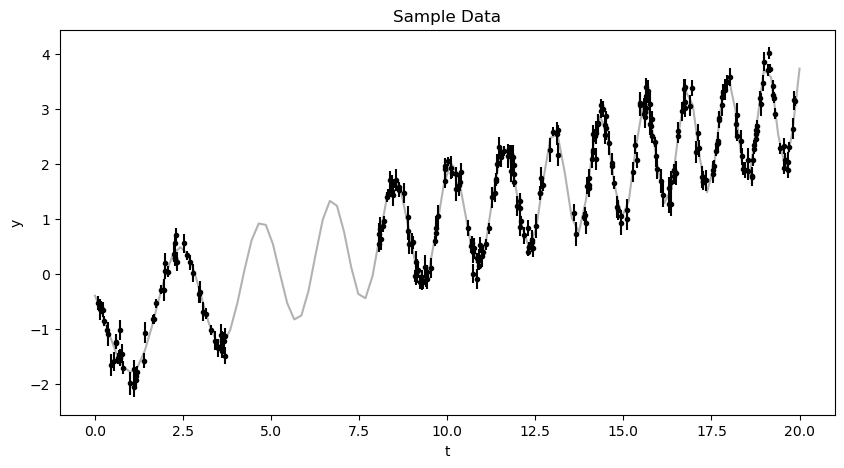

In [4]:
plt.figure(figsize=[10,5])
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("t")
plt.ylabel("y")
plt.title('Sample Data')

In [5]:
import celerite
from celerite import terms

# We would like a Gaussian Process Model for this function

So what should we do? Let's build a kernel! 


Let's start with a basic exponential kernel.

In [6]:
expkern = terms.RealTerm(1,0.4)

In [7]:
expgp = celerite.GP(expkern,mean=np.mean(y))
expgp.compute(t, yerr) 

In [44]:
x = np.linspace(0, 20, 5000)
exp_pred_mean, exp_pred_var = expgp.predict(y, x, return_var=True)
exp_pred_std = np.sqrt(exp_pred_var)

Text(0, 0.5, 'y')

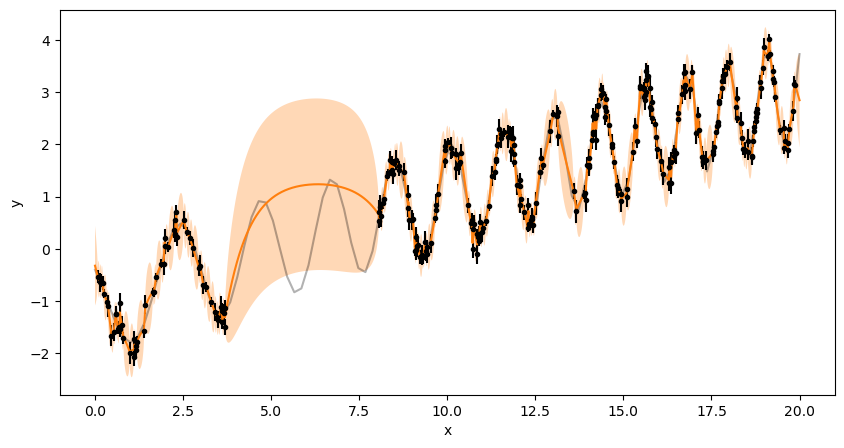

In [45]:
plt.figure(figsize=[10,5])
color = "#ff7f0e"
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, exp_pred_mean, color=color)
plt.fill_between(x, exp_pred_mean+exp_pred_std, exp_pred_mean-exp_pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")



This looks pretty good, but is it really? Could we do better?


In [46]:
print("Initial log likelihood: {0}".format(expgp.log_likelihood(y)))

Initial log likelihood: -138.56859389325805


Oh wow, that's super unlikely! Probably we can do better!

# Stochastic Harmonic Oscillator-based kernel

Let's try a model that's based on the stochastic harmonic oscillator kernel function (a built-in in Celerite).

In [47]:
# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

In [48]:
# A periodic component
Q = 1.0
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

In [49]:
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Initial log likelihood: 3.206976740012408


Find best fit params

In [52]:
x = np.linspace(0, 20, 5000)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

Text(0, 0.5, 'y')

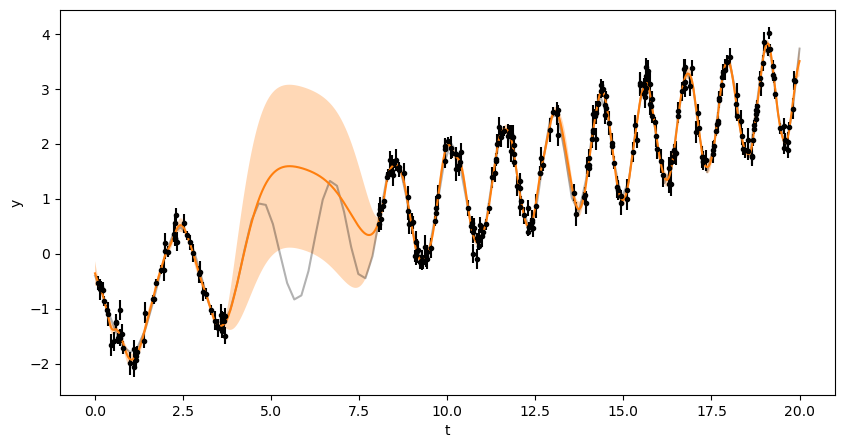

In [53]:
plt.figure(figsize=[10,5])
color = "#ff7f0e"
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("t")
plt.ylabel("y")



# Next Steps

Take this "pretty good" model and implement MCMC fitting. Create many, many Gaussian processes & come up with a true estimate for how well we can fit.